<h2><b>Wind Power Generation forecasting</b></h2>

In [84]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import sklearn 
from scipy import stats,signal
from sklearn.linear_model import LinearRegression
from datetime import datetime
import datetime as dt
from scipy import stats,signal
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # used
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

<h3><b>Data Acquisition</b></h3>

As first step we convert the dataset in a dataframe pandas and let’s take a first look at how it looks.

In [85]:
Wind_df = pd.read_csv("C:/Users/alesi/Desktop/Models/Progetto Models/WindEnergy.csv")
Wind_df

,utc_timestamp,wind_generation_actual,wind_capacity,temperature
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908
...,...,...,...,...
1089,2019-12-26 00:00:00+00:00,132739.0,50424.125,2.790
1090,2019-12-27 00:00:00+00:00,146590.0,50427.000,1.327
1091,2019-12-28 00:00:00+00:00,159126.0,50427.292,-1.441
1092,2019-12-29 00:00:00+00:00,349839.0,50434.750,-1.314


The dataframe has 4 columns:
- utc_timestamp : year/month/day from 2017/01/01 to 2019/12/30;
- wind_generation_actual : power generated by the turbines in Germany on a specific day;
- wind_capacity : total amount of power generated through a time interval;
- temperature : mean temperature on a specific day.

<h4><b>Check for null and redundant values</b></h4>

In [86]:
Wind_df.info()
# Check null values
Wind_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   utc_timestamp           1094 non-null   object 
 1   wind_generation_actual  1094 non-null   float64
 2   wind_capacity           1094 non-null   float64
 3   temperature             1094 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.3+ KB


utc_timestamp             0
wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

In [87]:
# Check duplicates
Wind_df[Wind_df.duplicated()]

,utc_timestamp,wind_generation_actual,wind_capacity,temperature


After these two preliminary analyses we can say that there are no null and redundant values.

In [88]:
Wind_df['utc_timestamp'] = pd.to_datetime(Wind_df['utc_timestamp'])
Wind_df.set_index('utc_timestamp', inplace=True)
Wind_df = Wind_df.asfreq('d')
Wind_df.head()


,wind_generation_actual,wind_capacity,temperature
utc_timestamp,,,
2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908


<h3><b>EDA and features overview</b></h3>

In this part we are gonna analyze the different features in order to have a first overview of the dataset's components.

In [89]:
Wind_df.describe().T

,count,mean,std,min,25%,50%,75%,max
wind_generation_actual,1094.0,305819.767824,205728.857915,16482.000,148552.75000,254332.5000,412570.500,998899.000
wind_capacity,1094.0,45066.022789,4315.838061,37149.130,41447.93750,46073.0000,49203.000,50452.000
temperature,1094.0,10.050167,7.739158,-9.363,3.57725,10.0465,16.566,28.241


Just looking at the table, we can see that there may be the presence of outliers in the wind_generation_actual column because there is a big gap between the 75% e the max value. But it is just a first looking analysis.

<AxesSubplot: >

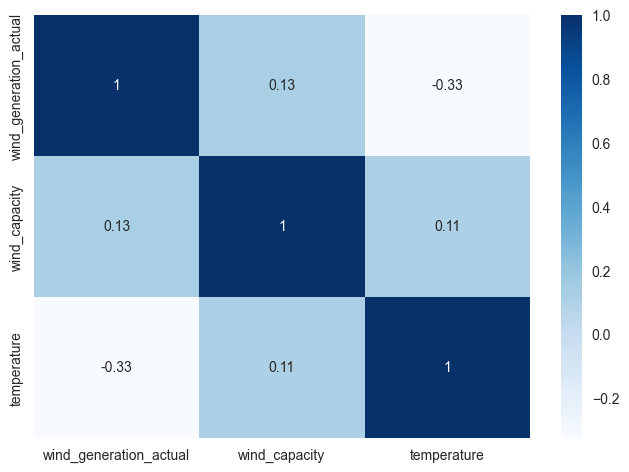

In [90]:
# Correlation matrix
corr = Wind_df.corr()
sns.heatmap(corr,annot=True,cmap='Blues')

The correlation between variables does not seem to be very strong. Note the negative correlation between wind_generation and temperatures due to warmer air, having the same composition as cooler air, contains less energy and needs to move at a higher speed to generate the same amount of power from a wind turbine.

<h5><b>Wind_generation_actual</b></h5>

Text(0.5, 1.0, 'Wind generation through the time')

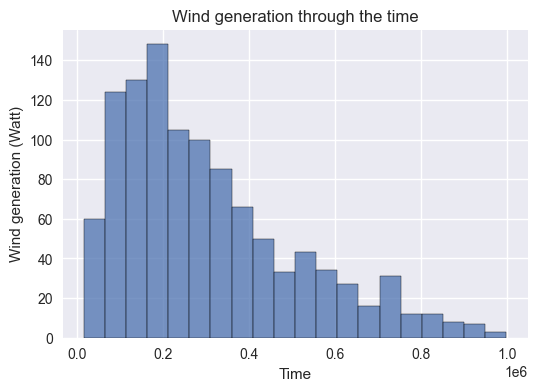

In [91]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_df.wind_generation_actual, bins=20)
plt.ylabel("Wind generation (Watt)")
plt.xlabel('Time')
plt.title("Wind generation through the time")

Text(0.5, 1.0, 'Wind generation through the time')

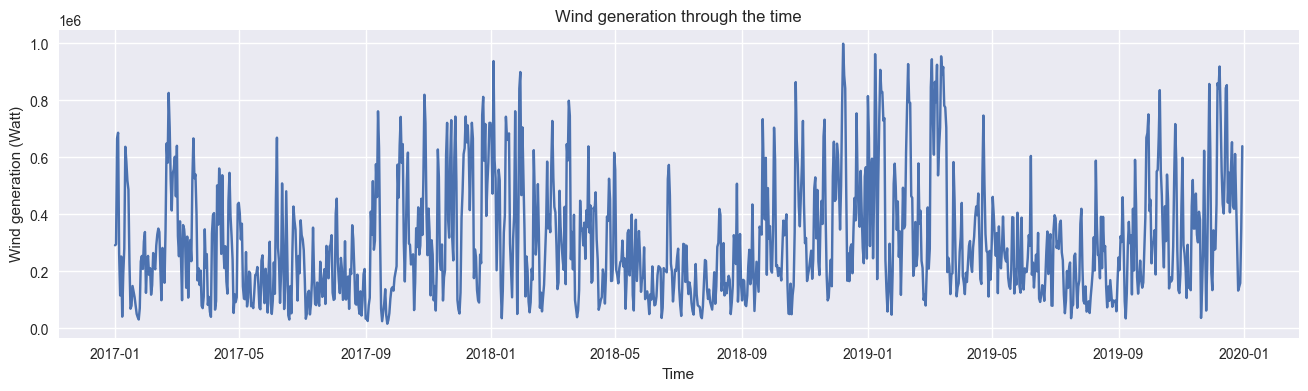

In [92]:
plt.figure(figsize=(16,4))
plt.plot(Wind_df['wind_generation_actual'])
plt.ylabel("Wind generation (Watt)")
plt.xlabel('Time')
plt.title("Wind generation through the time")

We can see that there are recursive patterns and cycles. During the summer time the power is lower than in the winter time so maybe it is a sign of seasonality in the time series.

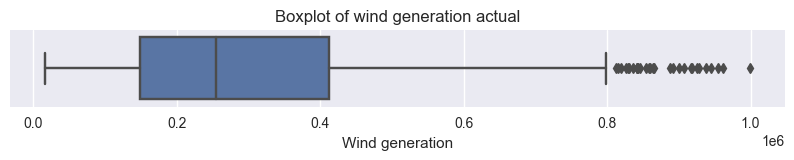

In [93]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_df['wind_generation_actual'])
plt.title('Boxplot of wind generation actual')
plt.xlabel('Wind generation')
plt.show()

We see that there are some outliers in the wind generation.

In [94]:
# Check the number of outliers in the wind_generation_actual
z_score = np.abs(stats.zscore(Wind_df['wind_generation_actual']))
outliers_num = len(np.where(z_score > 2)[0])
if outliers_num:
    print('wind_generation_actual: {}'.format(outliers_num))

wind_generation_actual: 66


The total number of outliers is 66 which is about 6% of the dataset. 

<h5><b>Wind_capacity</b></h5>

Text(0.5, 1.0, 'Wind capacity through the time')

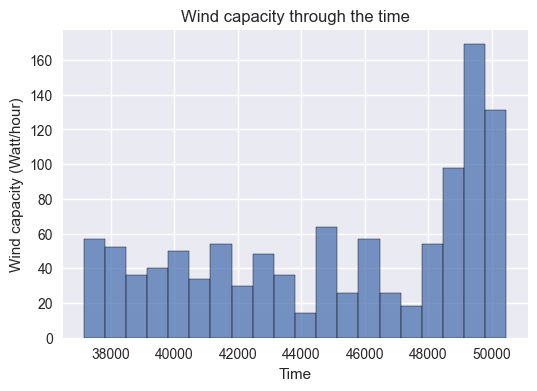

In [95]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_df.wind_capacity, bins=20)
plt.ylabel("Wind capacity (Watt/hour)")
plt.xlabel('Time')
plt.title("Wind capacity through the time")

Text(0.5, 1.0, 'Wind capacity through the time')

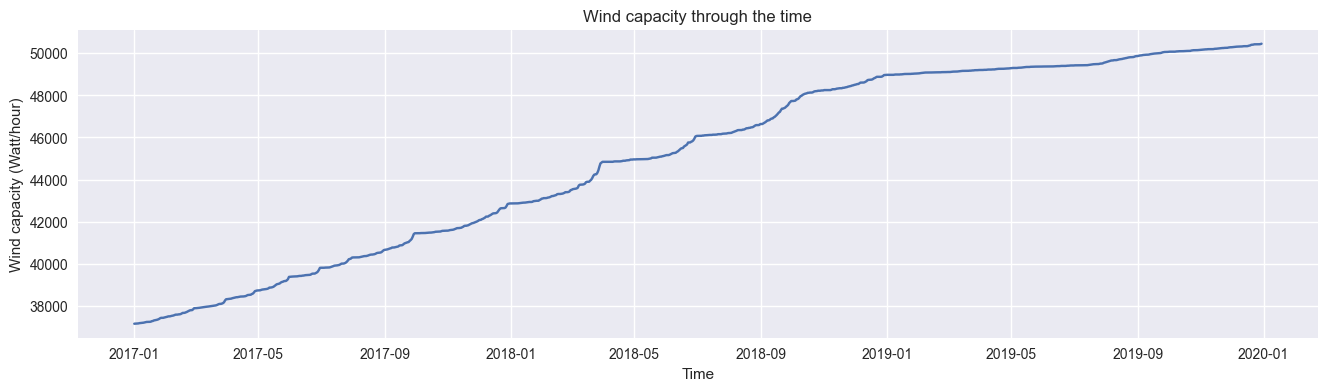

In [96]:
plt.figure(figsize=(16,4))
plt.plot(Wind_df['wind_capacity'])
plt.ylabel("Wind capacity (Watt/hour)")
plt.xlabel('Time')
plt.title("Wind capacity through the time")

Clearly there is a positive trend over the years but you can see some 'bumps' in the period from 09/2017 to 01/2019. These figures reflect Germany's strong commitment to renewable energy. Some explanation of the 'bumps' could be:
- End of Feed-in Tariff (2017): The significant spike in 2017 may be associated with the transition from the feed-in tariff system to an auction-based system in Germany. Developers rushed to complete projects before the transition.
- Initial Auction Cycles (2018-2019): The bumps seen in 2018 and early 2019 could be related to the initial cycles of the auction system, where project approvals and completions tend to cluster around specific auction dates.

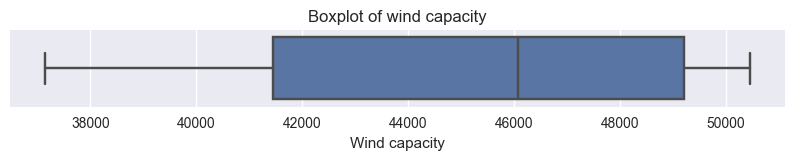

In [97]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_df['wind_capacity'])
plt.title('Boxplot of wind capacity')
plt.xlabel('Wind capacity')
plt.show()

There is no evidence of outliers.

<h5><b>Temperature</b></h5>

Text(0.5, 1.0, 'temperature through the time')

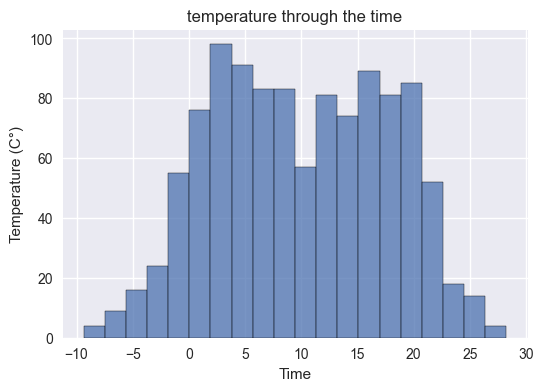

In [98]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_df.temperature, bins=20)
plt.ylabel("Temperature (C°)")
plt.xlabel('Time')
plt.title("temperature through the time")

Text(0.5, 1.0, 'Temperature through the time')

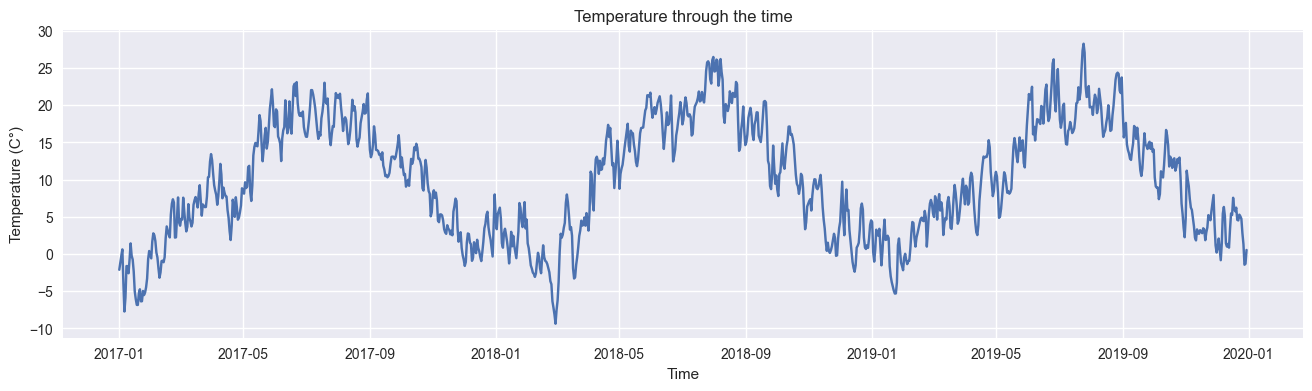

In [99]:
plt.figure(figsize=(16,4))
plt.plot(Wind_df['temperature'])
plt.ylabel("Temperature (C°)")
plt.xlabel('Time')
plt.title("Temperature through the time")

As we could expect you can see without any doubt a seasonality in the summer/winter periods.
An intresting fact could be the low point in the 2018 winter due to the phenomena called 'Beast from the East'. In March 2018, a significant high-pressure system over Scandinavia brought cold air masses from Siberia westwards across Europe, leading to severely cold temperatures.

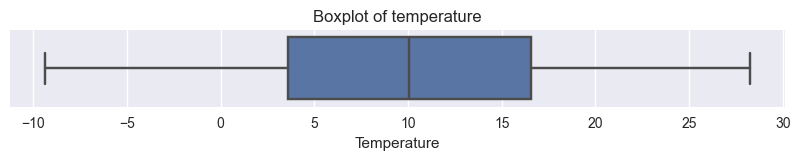

In [100]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_df['temperature'])
plt.title('Boxplot of temperature')
plt.xlabel('Temperature')
plt.show()

There don’t seem to be outliers.

<h3><b>Stationary test</b></h3>

The main aim of this project is to forecast the wind power generation for the last month of 2019 (December). First of all I will divide the dataset according to the goal.

In [101]:
# Splitting the dataset in the train and test set. 
train_data = Wind_df[:'2019-12-01']
test_data = Wind_df['2019-12-01':]
wind_generation_train = Wind_df['wind_generation_actual'][:'2019-12-01'] 
wind_generation_test = Wind_df['wind_generation_actual']['2019-12-01':]

<h5><b>ADFuller test</b></h5>

To determine if our data is stationary or not we have to use the ADFuller and the KPSS tests.

The **Augmented Dickey-Fuller** (ADF) test is a type of statistical test called a unit root test.
- Null Hypothesis (H0):  time series has a unit root, and it is non-stationary.
- Alternative Hypothesis (H1): time series does not have a unit root, meaning it is stationary.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [102]:
# ADF test
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

adfuller_test(wind_generation_train)    

ADF Statistic: -10.770881147570158
p-value:  2.3860555693459234e-19
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary


The p-value is less than 0.05 so we can reject the null hypothesis (H0) at the 5% significance level. This means that our time series is stationary.

<h5><b>KPSS test</b></h5>

The **KPSS** tests for the null hypothesis that the series is stationary around a deterministic trend. 
- Null Hypothesis (H0): time series is trend stationary.
- Alternative Hypothesis (H1): time series is not trend stationary.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data is trend stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data is not trend stationary.

In [103]:
# KPSS test
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

kpss_test(wind_generation_train)    

print('-------------------------------------------')

# KPSS test
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

kpss_test(wind_generation_train)   

KPSS Statistic: 0.16055636659786887
p-value:  0.037869694501775936
We can reject the null hypothesis (H0) --> data is not trend stationary
-------------------------------------------
KPSS Statistic: 0.29625428640285684
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Given the test results and the visual inspection of the time series plot, the data seems to exhibit a trend component. Therefore, it is more appropriate to model the series as trend stationary (regression='ct') rather than purely level stationary (regression='c').

The p-value is less than 0.05 for the trend stationary so we can reject the null hypothesis (H0) at the 5% significance level. This means that our time series is not trand stationary so we have to do differencing to get stationary but first we'll check the seasonality part.

<h3><b>Frequency analysis</b></h3>

We'll use the periodogram to estimate the power spectral density (PSD) of a signal. It helps in identifying the dominant frequencies present in the time series data.

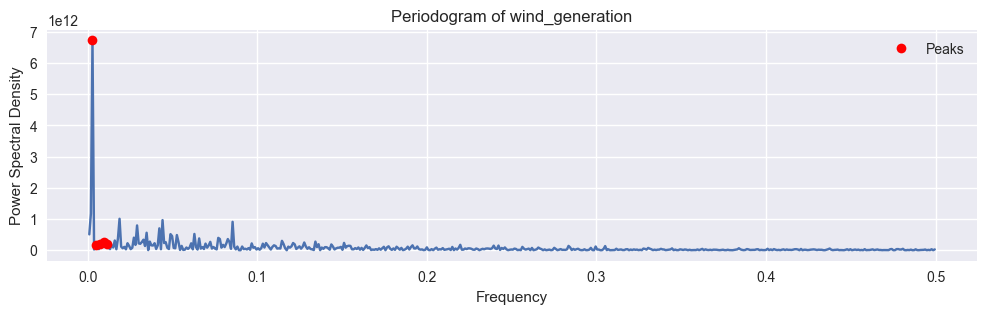

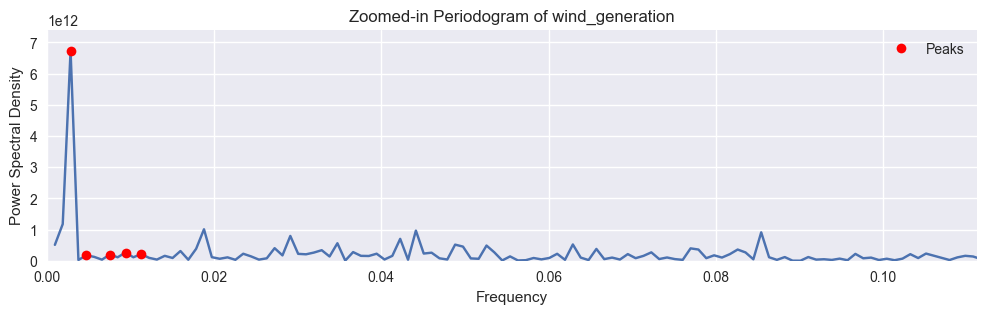

,Freq,Period,Power
0,0.002817,355.000,6.732934e+12
1,0.004695,213.000,1.724521e+11
2,0.007512,133.125,1.977423e+11
3,0.009390,106.500,2.634101e+11
4,0.011268,88.750,2.121807e+11


In [104]:
# Seasonality using the periodogram
Fs = 1 # our unit of measures is "days", thus 1 per day
f_per, Pxx_per = signal.periodogram(wind_generation_train,Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
f_per = f_per[1:] # Remove the Zero Frequency Component
Pxx_per = Pxx_per[1:]

# Find peaks
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_power = Pxx_per[peaks]

# Select only the first five peaks
peak_freq_top5 = peak_freq[:5]
peak_power_top5 = peak_power[:5]

# Plot the periodogram
plt.figure(figsize=(12, 3))
plt.plot(f_per, Pxx_per)
plt.plot(peak_freq_top5, peak_power_top5, 'ro', label='Peaks')
plt.title('Periodogram of wind_generation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot a zoomed-in view of the peaks
plt.figure(figsize=(12, 3))
plt.plot(f_per, Pxx_per)
plt.plot(peak_freq_top5, peak_power_top5, 'ro', label='Peaks')
plt.xlim(0, peak_freq_top5.max() + 0.1)  # Zoom in on the frequency range around the peaks
plt.ylim(0, peak_power_top5.max() + peak_power_top5.max() * 0.1)  # Zoom in on the power range around the peaks
plt.title('Zoomed-in Periodogram of wind_generation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Create and display a table of the first five peaks
table = {'Freq': peak_freq_top5, 'Period': 1/peak_freq_top5, 'Power': peak_power_top5}
peaks_tab = pd.DataFrame(table)
display(peaks_tab)


We see that the most highest frquencies represents the periods 355, 213, 133, 106 and 89 days. So we have five possibilities for the seasonalities. I'll use the seasonality of 355 approximated to 365 (a year) and then the 88 approximated to 90 (three months) reflects the seasons. I don't use the others periods 213 (seven months), 133 (four and a half months) and 106 (three and a half months) because do not seem relevant in my opinion. 

<h3><b>Seasonal difference for trend stationary</b></h3>

Let's go back to the stationary. Now that we have found the most frequent periods in frequency analysis we have to do a difference on the train dataset and then test the stationary.

Text(0.5, 1.0, 'Wind generation difference 365')

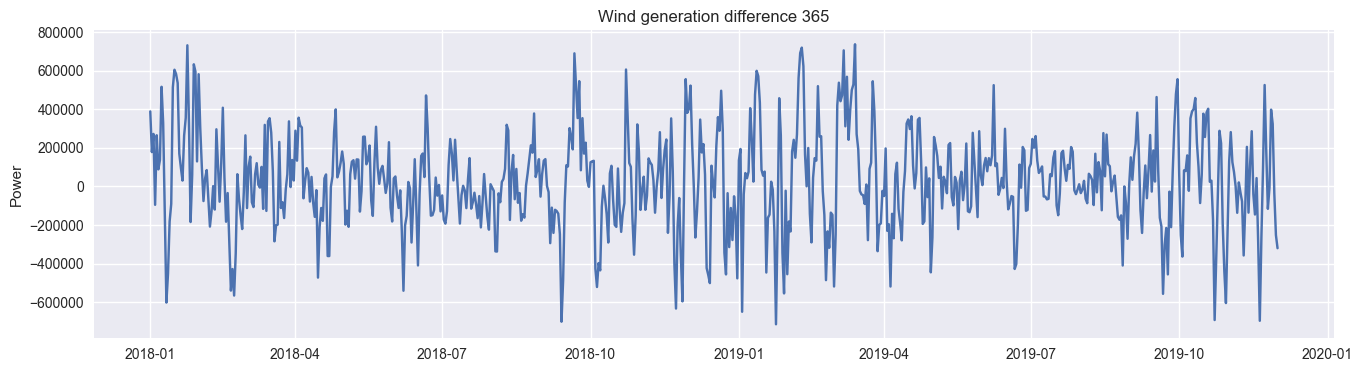

In [105]:
# 365 difference
wind_generation_diff365_train = wind_generation_train.diff(365).dropna()
train_data_diff365 = train_data.diff(365).dropna()
fig = plt.figure(figsize=(16,4))
plt.plot(wind_generation_diff365_train)
plt.ylabel('Power')
plt.title('Wind generation difference 365')

In [106]:
# Stationary test on 365 difference
adfuller_test(wind_generation_diff365_train)
print('--------------------------------')
kpss_test(wind_generation_diff365_train)

ADF Statistic: -13.767585382019107
p-value:  9.818651975747313e-26
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------
KPSS Statistic: 0.0605761165764053
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Our time serie is stationary and trend stationary.

Text(0.5, 1.0, 'Wind generation difference 365')

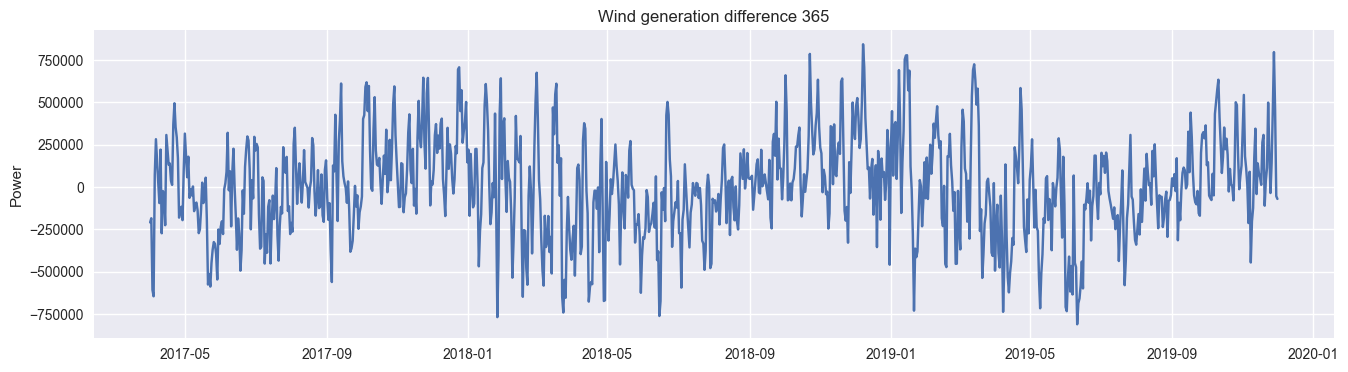

In [107]:
# 90 difference
wind_generation_diff90_train = wind_generation_train.diff(90).dropna()
train_data_diff90 = train_data.diff(90).dropna()
fig = plt.figure(figsize=(16,4))
plt.plot(wind_generation_diff90_train)
plt.ylabel('Power')
plt.title('Wind generation difference 365')

In [108]:
# Stationary test on 90 difference
adfuller_test(wind_generation_diff90_train)
print('---------------------------------')
kpss_test(wind_generation_diff90_train)

ADF Statistic: -11.433530381495444
p-value:  6.429922228041894e-21
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary
---------------------------------
KPSS Statistic: 0.15181791947598347
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Our time serie is stationary and trend stationary but with higher value of KPSS Statistic

<h3><b>ACF and PACF</b></h3>

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are tools used in time series analysis to identify the presence and strength of relationships between observations in a time series. These functions are particularly useful for determining the order of ARIMA models (AutoRegressive Integrated Moving Average).

If we see a lot of lags with values which are outside the confidence interval then it means that at this specific lag there is some correlation between the data and it is not a good sign.

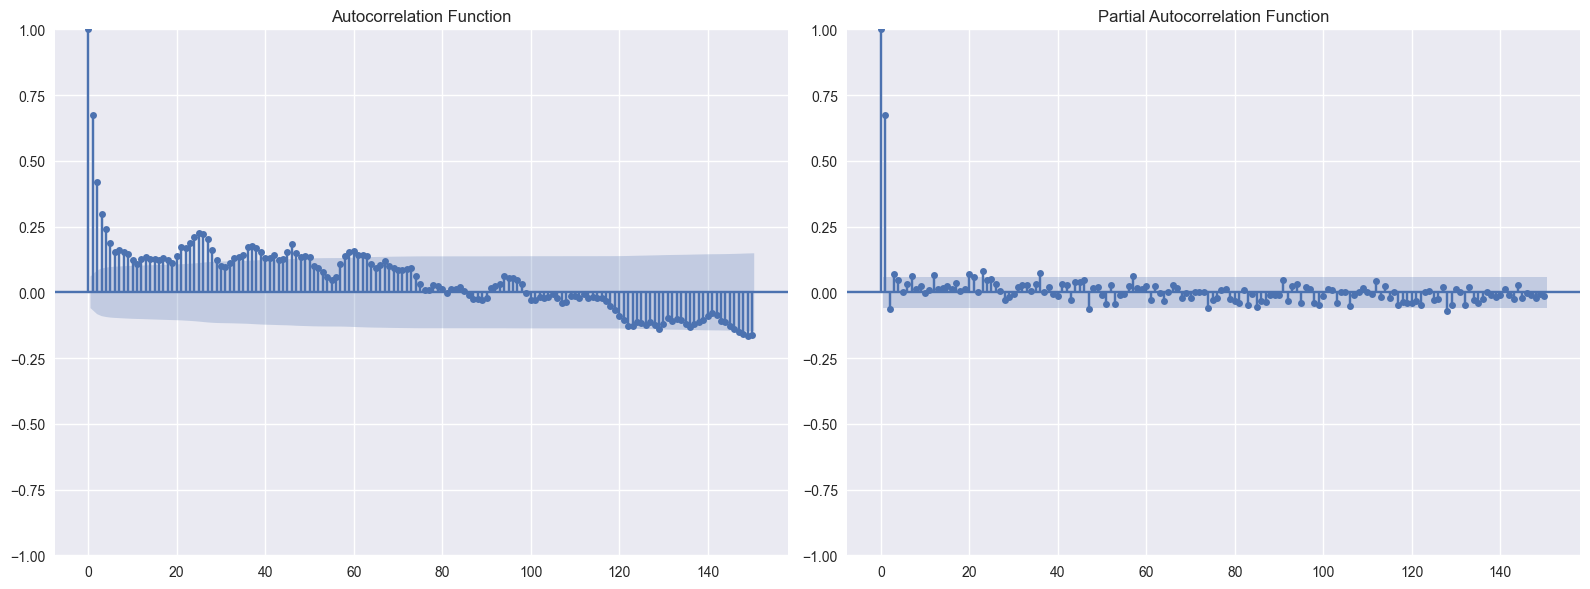

In [114]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(wind_generation_train, lags=150, ax=ax[0])
ax[0].set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(wind_generation_train, lags=150, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function')

# Show the plots
plt.tight_layout()
plt.show()